In [1]:
import cv2

Загрузка изображений в память

In [2]:
images = []
for i in range(1, 13):
    image_name = ('0' if i < 10 else '') + str(i) + '.tif'
    print(image_name + '    loaded')
    images.append(cv2.imread(image_name, cv2.IMREAD_GRAYSCALE))

01.tif    loaded
02.tif    loaded
03.tif    loaded
04.tif    loaded
05.tif    loaded
06.tif    loaded
07.tif    loaded
08.tif    loaded
09.tif    loaded
10.tif    loaded
11.tif    loaded
12.tif    loaded


## Поиск воспроизводимостей

In [3]:
import numpy as np
from scipy.spatial.distance import hamming
from numpy.linalg import norm as l2
import time
import matplotlib.pyplot as plt

Функция для вычисления воспроизводимостей

In [4]:
def get_repeatabilities(images, detector):
    # Находим дескрипторы
    descriptors = []
    # Также посчитаем время работы
    working_time = 0
    number_of_points = 0
    for image in images:
        if detector == 'ORB':
            ##########
            start_time = time.time()
            key_points, descripted = cv2.ORB_create().detectAndCompute(image, None)
            working_time += time.time() - start_time
            number_of_points += len(descripted)
            ##########
            
            descriptors.append(descripted)
            
        elif detector == 'Harris':
            ##########
            start_time = time.time()
            descripted = cv2.cornerHarris(image, 2, 3, 0.04)
            working_time += time.time() - start_time
            number_of_points += len(descripted)
            ##########
            
            descriptors.append(descripted)
            
        elif detector == 'SIFT':
            ##########
            start_time = time.time()
            key_points, descripted = cv2.SIFT_create().detectAndCompute(image, None)
            working_time += time.time() - start_time
            number_of_points += len(descripted)
            ##########
            
            descriptors.append(descripted)
            
        else:
            pass
    # И среднее время работы для одной точки
    time_per_point = working_time / number_of_points
    
    # Выбираем норму для сравнения
    norm = None
    if detector == 'ORB':
        norm = lambda x, y: hamming(x, y) * len(x)
    elif detector == 'Harris':
        norm = lambda x, y: l2(x - y)
    elif detector == 'SIFT':
        norm = lambda x, y: l2(x - y)
    else:
        pass

    # Считаем воспроизводимости
    repeatabilities = []
    for i, descriptor_1 in enumerate(descriptors):
        matched_points = np.zeros(len(descriptor_1))
        for j, descriptor_2 in enumerate(descriptors):
            if i == j:
                continue
            # Сравниваем два разных дескриптора
            for k, descripted_point in enumerate(descriptor_1):
                # находим совпадение (индекс ближайшего числа) во 2ом дескрипторе
                matched_point_idx = np.argmin(list(map(lambda x: norm(descripted_point, x), descriptor_2)))
                # проверяем обратное совпадение в 1ом дискрипторе
                if np.argmin(list(map(lambda x: norm(descriptor_2[matched_point_idx], x), descriptor_1))) == k:
                    matched_points[k] += 1   
            
        repeatabilities.append(np.mean(matched_points) / (len(descriptors) - 1))
        
    return repeatabilities, working_time, time_per_point

### ORB

In [5]:
orb_rep, orb_time, orb_speed = get_repeatabilities(images, 'ORB')

In [6]:
print("Время работы детектора: %.4f мс" % (1000 * orb_time / len(images)))
print("Время работы детектора в пересчете на одну точку: %.4f мс" % (orb_speed * 1000))

Время работы детектора: 11.6311 мс
Время работы детектора в пересчете на одну точку: 0.0243 мс


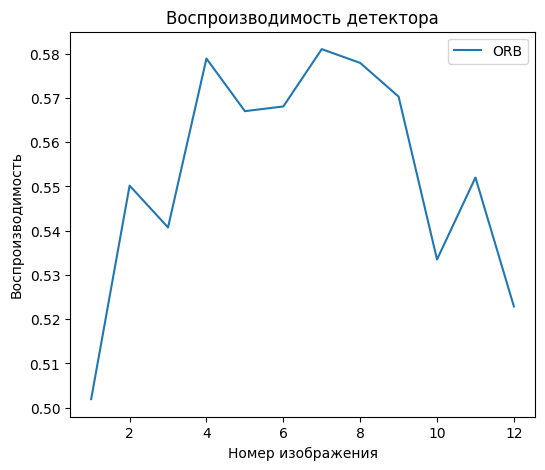

In [7]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(np.arange(1, 13), orb_rep, label='ORB')   

plt.title('Воспроизводимость детектора')
plt.xlabel('Номер изображения')
plt.ylabel('Воспроизводимость')

plt.legend()
plt.show()

### Harris

In [8]:
harris_rep, harris_time, harris_speed = get_repeatabilities(images, 'Harris')

In [9]:
print("Время работы детектора: %.4f мс" % (1000 * harris_time / len(images)))
print("Время работы детектора в пересчете на одну точку: %.4f мс" % (harris_speed * 1000))

Время работы детектора: 1.7433 мс
Время работы детектора в пересчете на одну точку: 0.0073 мс


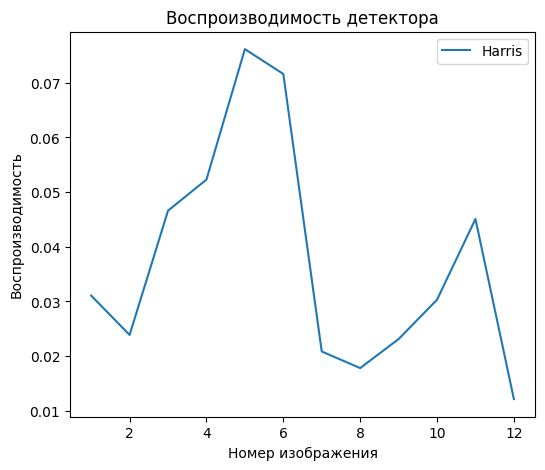

In [10]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(np.arange(1, 13), harris_rep, label='Harris')      

plt.title('Воспроизводимость детектора')
plt.xlabel('Номер изображения')
plt.ylabel('Воспроизводимость')

plt.legend()
plt.show()

### SIFT

In [11]:
sift_rep, sift_time, sift_speed = get_repeatabilities(images, 'SIFT')

In [12]:
print("Время работы детектора: %.4f мс" % (1000 * sift_time / len(images)))
print("Время работы детектора в пересчете на одну точку: %.4f мс" % (sift_speed * 1000))

Время работы детектора: 59.1613 мс
Время работы детектора в пересчете на одну точку: 0.0963 мс


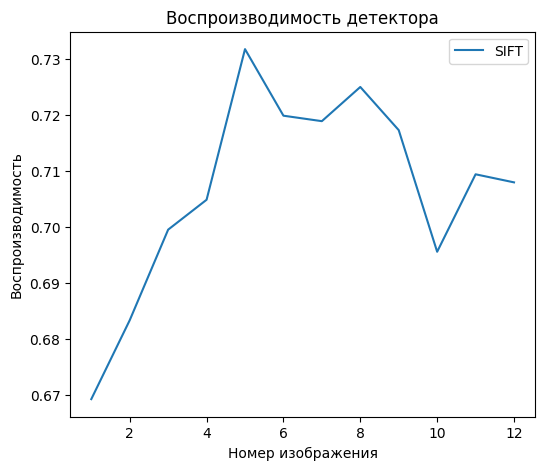

In [13]:
fig, ax = plt.subplots(figsize=(6, 5))   
ax.plot(np.arange(1, 13), sift_rep, label='SIFT')    

plt.title('Воспроизводимость детектора')
plt.xlabel('Номер изображения')
plt.ylabel('Воспроизводимость')

plt.legend()
plt.show()

## Сравнение воспроизводимостей

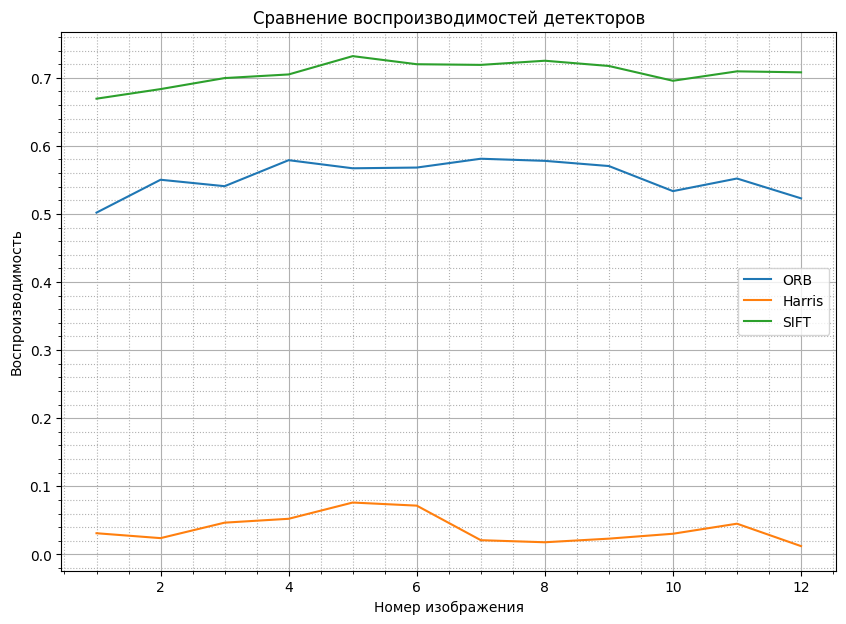

In [14]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(np.arange(1, 13), orb_rep, label='ORB')
ax.plot(np.arange(1, 13), harris_rep, label='Harris')    
ax.plot(np.arange(1, 13), sift_rep, label='SIFT')    

ax.grid(which='major')
ax.minorticks_on()
ax.grid(which='minor', linestyle = ':')

plt.title('Сравнение воспроизводимостей детекторов')
plt.xlabel('Номер изображения')
plt.ylabel('Воспроизводимость')

plt.legend()
plt.show()

In [16]:
print('Детектор | Время работы (мс) | Время работы для 1 точки (мс)')
print('Harris   |   %2.4f          |   %.4f' % (1000 * harris_time / len(images), harris_speed * 1000))
print('ORB      |   %2.4f         |   %.4f' % (1000 * orb_time / len(images), orb_speed * 1000))
print('SIFT     |   %2.4f         |   %.4f' % (1000 * sift_time / len(images), sift_speed * 1000))

Детектор | Время работы (мс) | Время работы для 1 точки (мс)
Harris   |   1.7433          |   0.0073
ORB      |   11.6311         |   0.0243
SIFT     |   59.1613         |   0.0963


#### Выводы

Воспроизводимость Harris довольно низкая по сравнению с остальными. Лучшие показатели у SIFT - но и работает он дольше.